In [1]:
import numpy as np
from scipy.stats import norm, lognorm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append("..")
from src.dataset import CRKPTransmissionSimulator
from src.approx_bc import abc_rejection_sampler
from src.utils import get_results
from timeit import default_timer as timer
import matplotlib.gridspec as gs

In [2]:
## load data
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'

SCALE = np.array([129., 28., 38., 35., 27., 17., 95])

labels_full = ["Facility", "Floor 1", "Floor 2", "Floor 3", "Floor 4", "SCU", "Room"]

In [3]:
with open(f"{epi_dir}/observed_data.npy", "rb") as f:
            x_o = np.load(f)

# Data Visualization

In [4]:
crkp_model = CRKPTransmissionSimulator(epi_dir, 0, 1, heterogeneous=False)
x_baseline = crkp_model.CRKP_simulator(-1e8, 100)

infections = pd.read_csv(f"{epi_dir}/infections.csv", index_col=0)
infections.columns=np.arange(53)

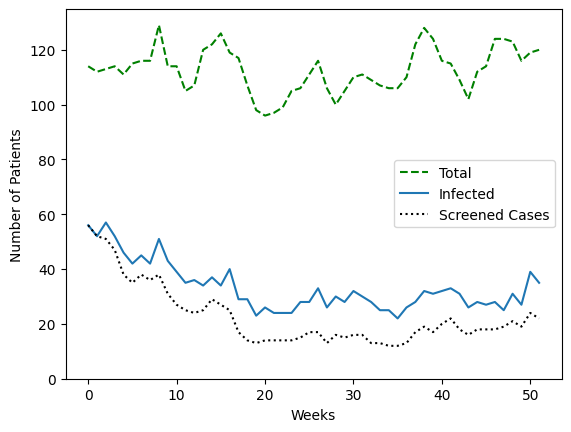

In [5]:
NN = infections.notna().sum(0)[:-1]
II = (infections == 1).sum(0)[:-1]
sns.lineplot(NN, color="green", linestyle="--", label="Total")
sns.lineplot(II, label="Infected")
sns.lineplot(x_baseline[:-1], linestyle=":", color="k", label="Screened Cases")
plt.ylim(bottom=0)
plt.ylabel("Number of Patients")
plt.xlabel("Weeks")
plt.savefig("images/crkp.png")
plt.show()

In [6]:
floor_pops = []
for i in [1,2,3,4,6]:
    floor_pops.append((crkp_model.F == i).sum(0))
floor_pops = np.stack(floor_pops)

floor_cases = x_o[1:6,]

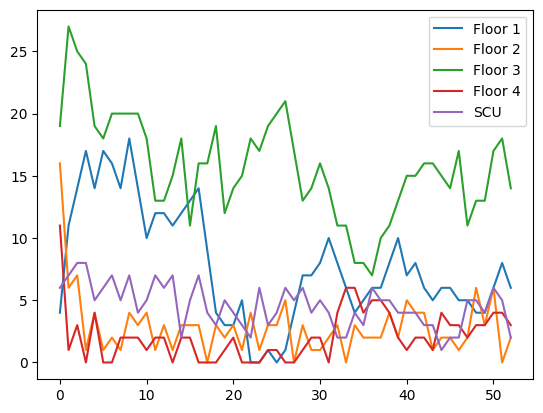

In [7]:
labels=["Floor 1", "Floor 2", "Floor 3", "Floor 4", "SCU"]
for i, label  in enumerate(labels):
    # temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    plt.plot(floor_cases[i], label=label)
plt.legend()
plt.show()

/var/folders/sk/4ngl_8x117n6zr60rtkvrr300000gn/T/ipykernel_3793/2927248741.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(floor_cases[i] / floor_pops[i], label=label)


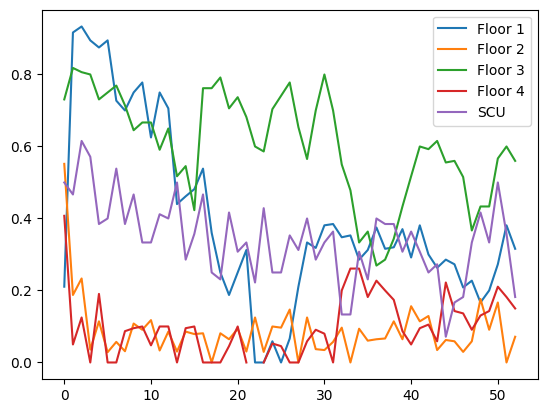

In [8]:
for i, label  in enumerate(labels):
    # temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    plt.plot(floor_cases[i] / floor_pops[i], label=label)
plt.legend()
plt.show()

In [9]:
# average case burden
for i, lab in enumerate(labels):
    temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    avg_burden = np.median(floor_cases[i] / temp_pop) # median is clearer
    print(f"{lab}: {avg_burden:.2f}")

Floor 1: 0.32
Floor 2: 0.08
Floor 3: 0.60
Floor 4: 0.10
SCU: 0.33


In [10]:
np.median(II / NN)

0.27055180180180183

## homogeneous run

In [12]:
prior_mu = -1
prior_sigma = 1
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=False)

In [13]:
# best run: n_sample = 4k, d_model = 80 patience = 50
mu = -0.026 # -.282 # 0.002
sigma = 0.171 # 0.157 # 0.169

d = norm(loc = mu, scale = sigma)
print(np.exp(d.ppf(0.05)), np.exp(d.ppf(0.95)))
print(np.exp(mu + sigma**2/2))

0.7354520239671298 1.2908100540971774
0.988685001612919


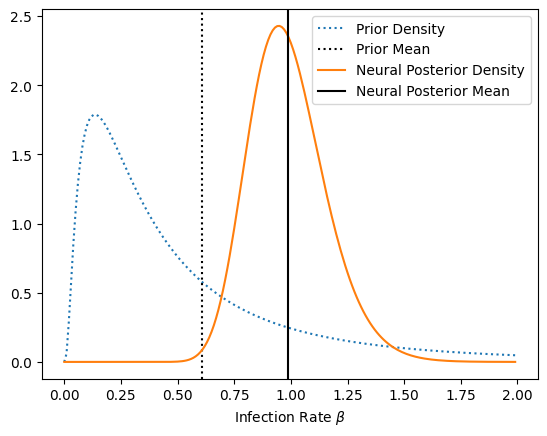

In [14]:
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
prior = norm(prior_mu, prior_sigma)
x = np.arange(0., 2, 0.01)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Neural Posterior Density")
plt.axvline(posterior_mean, color="k", label="Neural Posterior Mean")
ax.set_xlabel(r"Infection Rate $\beta$")
plt.legend()
# plt.savefig("images/crkp_homog.png")
plt.show()

## prior predictive checks

In [25]:
prior_mu = -60
prior_sigma = 1
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=False, mult=True)

In [32]:
1 - np.exp(1 * -60 * 10 / 120)

0.9932620530009145

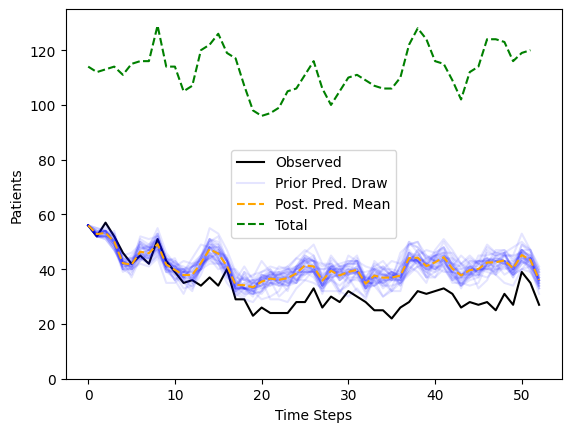

In [26]:
prior = norm(prior_mu, prior_sigma)
K = 30
T = x_o.shape[1]
npe_sample = prior.rvs(size=K, random_state=2)
prior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    prior_predictive[i] =  np.array(x_rep)
p_mean = prior_predictive.mean(0)
labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(p_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc1.png")
plt.ylim(0, 135)
plt.show()

#### posterior predictive checks

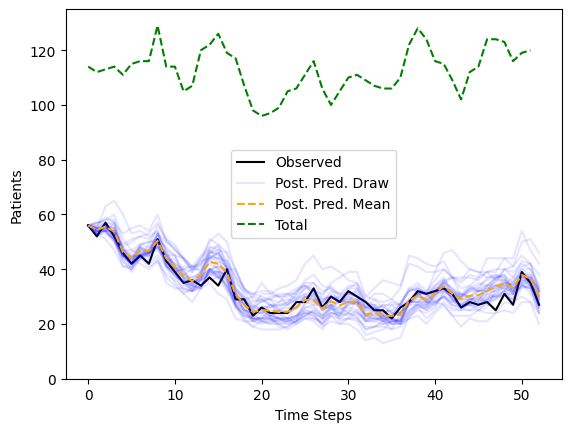

In [23]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc1.png")
plt.ylim(0, 135)
plt.show()

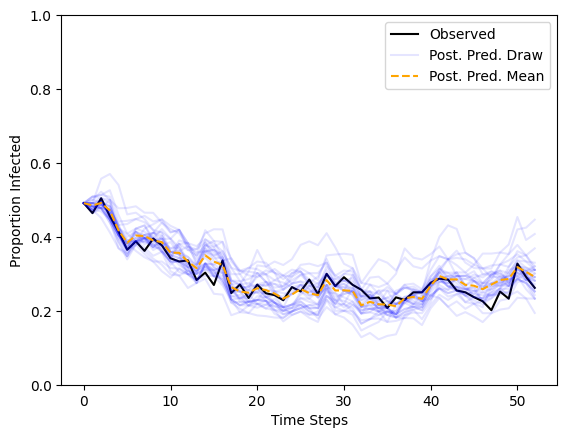

In [24]:
neural_posterior = norm(mu, sigma)
K = 30
T = x_o.shape[1]
pop = crkp_model.W.sum(0)
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i) / pop
    posterior_predictive[i] =  np.array(x_rep)
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0] / pop
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(x_baseline, label="Only Admitted", linestyle=":", color="k")
# plt.plot(pop, label="Population", color="g", linestyle=":")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.ylim(0, 1)
# plt.savefig("images/crkp_ppc2.png")
plt.show()

## Heterogeneous

In [14]:
prior_mu =  np.zeros(7)  - 100
prior_sigma = np.ones(7)

#### prior predictive checks

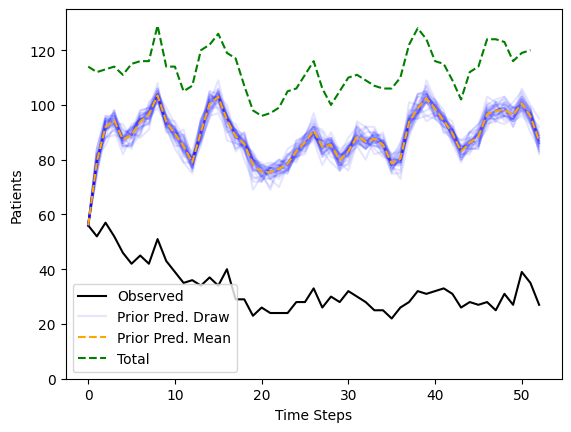

In [15]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, np.diag(prior_sigma), heterogeneous=True, mult=True)
neural_posterior = multivariate_normal(prior_mu, np.diag(prior_sigma))
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[0] * SCALE[0])
pp_mean = posterior_predictive.mean(0)
labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_prior_check_het.png")
plt.ylim(0, 135)
plt.show()

In [13]:
# df_het = get_results("../multirun/2024-10-15/10-20-26") # 3k samples, dmod 48, wd 0.01
df_het = get_results("../multirun/2024-10-21/15-49-43") # multiplicative rates

In [16]:
df_het

,N,_target_,batch_size,d_model,dropout,lr,mean_field,mu,n_sample,prior_mu,prior_sigma,seed,sigma,val_loss,weight_decay
0,-1,src.model.GaussianDensityNetwork,None,48,0.0,0.001,False,"[[-0.8756362795829773, 0.09962598234415054, -0...",3000,"[0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]",5,"[[0.13786345720291138, -0.08212116360664368, -...",7.701249,0.01
1,-1,src.model.GaussianDensityNetwork,None,48,0.0,0.001,False,"[[-0.3303450644016266, -0.23768670856952667, -...",3000,"[0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]",5,"[[0.5482251048088074, -0.08679034560918808, -0...",7.132537,0.01


In [18]:
mu = np.array(df_het["mu"].iloc[1][0])
sigma = np.array(df_het["sigma"].iloc[1])
rates = []
for i in range(7):
    rates.append(np.exp(mu[i] + sigma[i][i]/2))
rates = np.array(rates)

In [19]:
rates

array([0.94531931, 1.17672015, 0.87203588, 1.78199884, 1.35752184,
       1.5920244 , 0.93228966])

#### posterior predictive checks

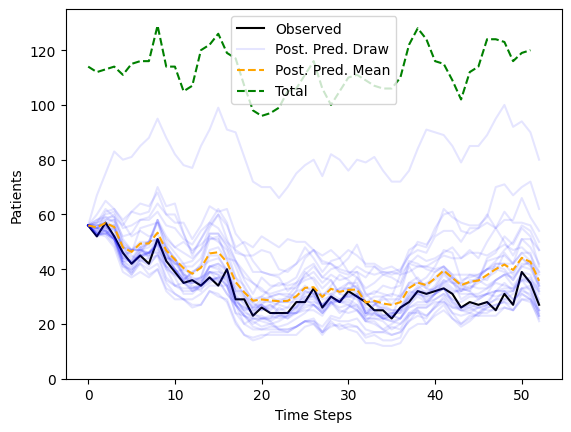

In [20]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
j = 0
neural_posterior = multivariate_normal(mu, sigma)
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[j] * SCALE[j])
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[j]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
# plt.savefig("images/crkp_ppc_het.png")
plt.ylim(0, 135)
plt.show()

## Interventions

In [30]:
pis = [
    [0., 1, 1, 1, 1, 1, 1],
    np.full((7,), 2),
    [1, 1, 1, 1 / rates[3], 1, 1, 1]
]
intervention = np.empty((K, len(pis), T))
for j, pi in enumerate(pis):
    crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True, pi=pi)
    for i in range(K):
        x_rep = crkp_model.CRKP_simulator(npe_sample[i], i * 2)
        intervention[i,j] =  np.array(x_rep)[0] * SCALE[0]
intervention = intervention.mean(0)

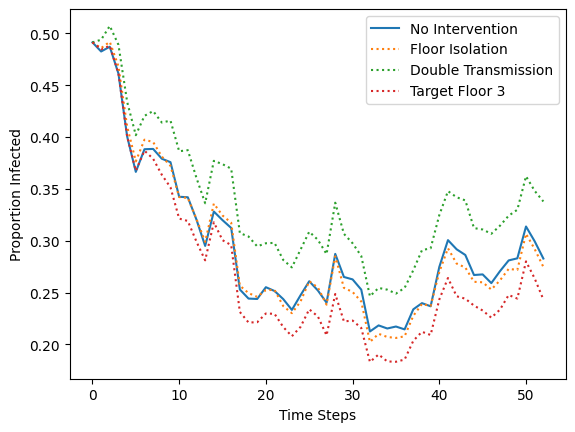

In [31]:
# plt.plot(I_o / pop, label="Observed", color="k", linestyle=":")
plt.plot(pp_mean / pop, label="No Intervention", linestyle="-")
plt.plot(intervention[0] / pop, label="Floor Isolation", linestyle=":")
plt.plot(intervention[1] / pop, label="Double Transmission", linestyle=":")
# plt.plot(intervention[2] / pop , label="Outside Only", color="k", linestyle="-")
plt.plot(intervention[2] / pop , label="Target Floor 3", linestyle=":")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/crkp_intervention.png")
plt.show()

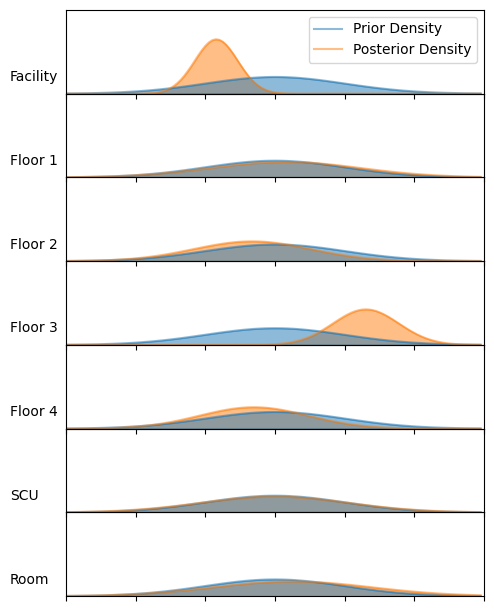

In [31]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
x = np.arange(-3, 3, 0.05)
axes = []
alpha = 0.5
for i in range(7):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = norm.pdf(x, prior_mu[i], np.sqrt(prior_sigma[i]))
    posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 2)
    axes[-1].set_xlim(-3, 3)

    axes[-1].set_yticks([])

    if i < 8 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate (Log-scale)")

    axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(-3.8, 0.3, labels_full[i])
grid.update(hspace= -.0)
plt.tight_layout()
plt.savefig("images/crkp_compare_het.png")
plt.show()
    

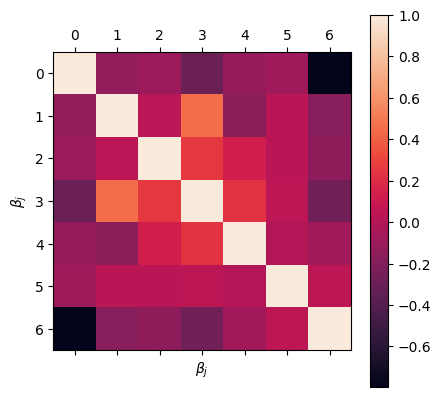

In [23]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
# plt.savefig("images/crkp_corr.png")
plt.show()

In [34]:
corr[0]

array([ 1.        , -0.22993806, -0.40569943, -0.10024273, -0.26978856,
       -0.01499195, -0.25635746])

#### make me a table jack

In [72]:
het_table = {"Rate": labels_full, 
             "Posterior Mean": np.round(np.array(rates), 3), 
             "CI": []}

for i in range(7):
    dist = norm(mu[i], np.sqrt(sigma[i][i]))
    het_table["CI"].append(
        (np.round(np.exp(dist.ppf(0.05)), 3), 
         np.round(np.exp(dist.ppf(0.95)), 3)))

In [73]:
het_table = pd.DataFrame(het_table)

In [74]:
print(het_table.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
Rate & Posterior Mean & CI \\
\midrule
Facility & 0.452000 & (0.26, 0.714) \\
Floor 1 & 2.077000 & (0.196, 6.848) \\
Floor 2 & 1.031000 & (0.18, 2.894) \\
Floor 3 & 4.116000 & (1.699, 7.988) \\
Floor 5 & 1.001000 & (0.205, 2.664) \\
SCU & 1.737000 & (0.174, 5.658) \\
Room & 2.448000 & (0.197, 8.328) \\
\bottomrule
\end{tabular}



In [68]:
np.exp(0.5)

1.6487212707001282

In [69]:
dist = norm(0, 1)

In [71]:
np.exp(dist.ppf(0.05)), np.exp(dist.ppf(0.95))

(0.19304081669873652, 5.180251602233012)

In [ ]:
# neural_posterior = multivariate_normal(mu, sigma)
# K = 30
# T = x_o.shape[1]
# npe_sample = neural_posterior.rvs(size=K, random_state=2)
# posterior_predictive = np.empty((K, T))
# for i in range(K):
#     x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
#     posterior_predictive[i] =  np.array(x_rep[j] * SCALE[j])
# pp_mean = posterior_predictive.mean(0)

# Multiplicative Hazards

In [6]:
prior_mu =  np.zeros(7)
prior_sigma = np.ones(7)

/Users/pchatha/crkp/notebooks/../src/dataset/crkp.py:124: RuntimeWarning: overflow encountered in exp
  hazard = np.exp(hazard) # why not..


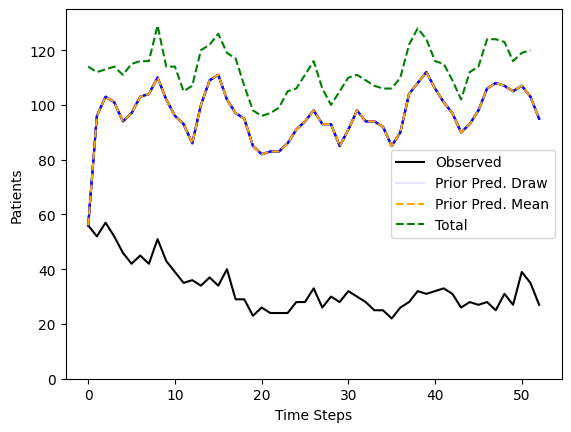

In [9]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True, mult=True)
neural_posterior = multivariate_normal(prior_mu, np.diag(prior_sigma))
K = 30
T = x_o.shape[1]
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[0] * SCALE[0])
pp_mean = posterior_predictive.mean(0)
labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[0]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
plt.savefig("images/crkp_prior_check_het.png")
plt.ylim(0, 135)
plt.show()

## ABC Comparison

In [11]:
summarize = False #True
hetero = True


prior_mu = np.zeros(7)
prior_sigma = np.ones(7)
model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma,
                                  heterogeneous=hetero)

In [12]:
prior_sampler = lambda: model.sample_logbeta(1)
simulator = lambda theta, seed: model.CRKP_simulator(theta, seed)

S = 100
epsilon = 1.1
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, (x_o.T / SCALE).T, max_attempts=15000,
    summarize=summarize
)

Attempts: 5,000
Time lapsed: 47.60 seconds
With tolerance 1.1, acceptance rate: 0.014453
Total number of attempts: 6,919


In [13]:
infections = pd.read_csv(f"{epi_dir}/infections.csv", index_col=0)
infections.columns=np.arange(53)

In [14]:
posterior_sample.mean(0)

array([-0.9403621 ,  0.00303274, -0.18139139,  1.084848  , -0.20674746,
        0.00448193, -0.01731925], dtype=float32)

In [15]:
posterior_sample.std(0)

array([0.46642452, 0.97926843, 0.98592436, 0.7454014 , 0.9108873 ,
       0.964066  , 0.85066247], dtype=float32)

In [37]:
abc_rates = np.exp(posterior_sample).mean(0)

abc_lower = np.round(np.quantile(np.exp(posterior_sample), 0.05, axis=0), 3)

abc_upper = np.round(np.quantile(np.exp(posterior_sample), 0.95, axis=0), 3)

abc_table = {"Rate": labels_full, 
             "Posterior Mean": np.round(np.array(abc_rates), 3), 
             "CI": []}

for i in range(7):
    abc_table["CI"].append((abc_lower[i], abc_upper[i]))

abc_table = pd.DataFrame(abc_table)
print(abc_table.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
Rate & Posterior Mean & CI \\
\midrule
Facility & 0.430000 & (0.144, 0.738) \\
Floor 1 & 1.644000 & (0.181, 5.75) \\
Floor 2 & 1.254000 & (0.157, 3.699) \\
Floor 3 & 3.691000 & (0.629, 7.518) \\
Floor 5 & 1.213000 & (0.19, 3.554) \\
SCU & 1.574000 & (0.185, 4.075) \\
Room & 1.399000 & (0.267, 3.706) \\
\bottomrule
\end{tabular}



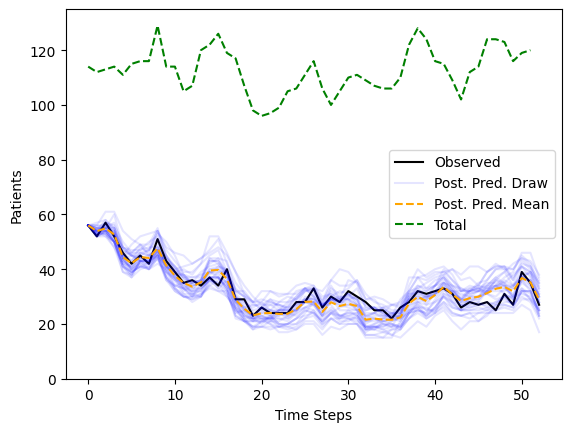

In [25]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
j = 0
K = 30
T = x_o.shape[1]
posterior_predictive = np.empty((K, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(posterior_sample[i], i)
    posterior_predictive[i] =  np.array(x_rep[j] * SCALE[j])
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o)[j]
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
sns.lineplot(NN, color="green", linestyle="--", label="Total")
plt.legend()
plt.ylabel("Patients")
plt.xlabel("Time Steps")
plt.savefig("images/crkp_ppc_het_abc.png")
plt.ylim(0, 135)
plt.show()

In [95]:
# crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
# j = 3
# K = 30
# T = x_o.shape[1]
# posterior_predictive = np.empty((K, T))
# for i in range(K):
#     x_rep = crkp_model.CRKP_simulator(posterior_sample[i], i)
#     posterior_predictive[i] =  np.array(x_rep[j])
# pp_mean = posterior_predictive.mean(0)
# labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
# I_o = np.array(x_o)[j]
# plt.plot(I_o, label="Observed", color="k")
# plt.plot(posterior_predictive.T, 
#          label=labels, color="b",
#          alpha=0.1)
# plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
#          color="orange")
# # sns.lineplot(NN, color="green", linestyle="--", label="Total")
# plt.legend()
# plt.ylabel("Patients")
# plt.xlabel("Time Steps")
# # plt.savefig("images/crkp_ppc_het.png")
# # plt.ylim(0, 135)
# plt.show()

In [96]:
# posterior predictive check for floor

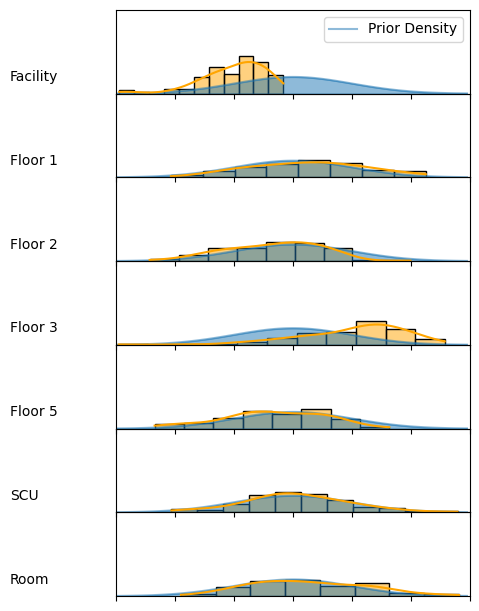

In [97]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
xmin, xmax = -3, 3

x = np.arange(xmin, xmax, 0.05)
axes = []
alpha = 0.5
for i in range(7):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = norm.pdf(x, prior_mu[i], np.sqrt(prior_sigma[i]))
    # posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.histplot(posterior_sample[:, i], color="orange", ax=axes[-1], legend=legend, alpha=alpha, stat="density",
                kde=True, label="ABC Posterior")

    post_mean = np.mean(posterior_sample[:, i])

    # plt.axvline(post_mean, color="k", linestyle="--")

    # sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 2)
    axes[-1].set_xlim(xmin, xmax)

    axes[-1].set_yticks([])

    if i < 8 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate (Log-scale)")

    # axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(-4.8, 0.3, labels_full[i])
grid.update(hspace= -.0)
plt.tight_layout()
# plt.savefig("images/crkp_compare_het.png")
plt.show()

In [98]:
abc_corr = np.corrcoef(posterior_sample.T)

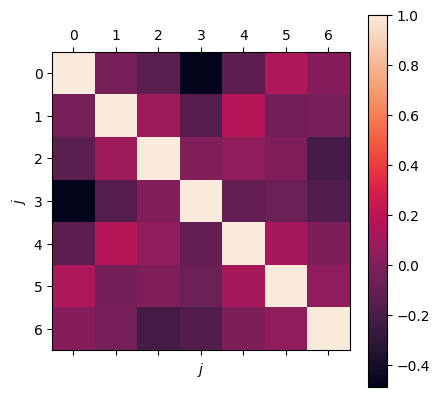

In [99]:
plt.matshow(abc_corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$j$")
plt.ylabel(r"$j$")
# plt.savefig("images/corr.png")
plt.show()